# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading Data

In [2]:
df=pd.read_csv('features_data.csv')
df['Label'] = df['Label'].replace({0: 'Tr.B', 1: 'IoT.M', 2: 'IoT.M', 3: 'IoT.M', 4: 'IoT.B', 5: 'Tr.M'})

In [3]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

df1=df[:1000000]

# Filter only benign data for training
benign_df = df1[df1['Label'].isin(['Tr.B', 'IoT.B'])]
malicious_df = df1[df1['Label'].isin(['Tr.M', 'IoT.M'])]

In [4]:
import pandas as pd

# Assuming the "Label" column contains categorical values before replacement
df1["Label"] = df1["Label"].astype(str)  # Ensure it's a string type

# Extract only IoT.B for training
train_df = df1[df1["Label"] == "Tr.B"]

# Convert labels to numerical values after filtering
df1["Label"] = df1["Label"].replace({'Tr.B': 0, 'IoT.B': 0, 'Tr.M': 1, 'IoT.M': 1})

# Ensure test_df contains all other cases (Tr.B, Tr.M, IoT.M)
test_df = df1.drop(train_df.index)  # Everything except IoT.B goes to testing

# Display the data split
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)


Training Data Shape: (55643, 39)
Testing Data Shape: (944357, 39)


In [5]:
from collections import Counter
Counter(train_df['Label'])

Counter({'Tr.B': 55643})

In [6]:
from collections import Counter
Counter(test_df['Label'])

Counter({0: 686382, 1: 257975})

### Basic Statistics

In [7]:
df1.describe()

,Protocol,TCP,UDP,TTL,ACK,SYN,FIN,PSH,URG,RST,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.353941,0.967809,0.032181,87.627329,0.880348,0.155790,0.136658,0.311871,0.0,0.040118,...,1.764234,13706.625813,2340.632905,4562.104087,0.967811,0.032179,6.350474,29048.934705,107.018186,93.413975
std,1.941360,0.176507,0.176481,31.457677,0.324554,0.362656,0.343486,0.463258,0.0,0.196236,...,0.638017,52123.795028,18728.911721,27545.818611,0.174887,0.174862,1.932063,106636.045546,341.717242,239.373697
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,63.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.735299,110.000000,18.000000,98.000000,1.000000,0.000000,6.000000,327.822695,0.000000,7.612245
50%,6.000000,1.000000,0.000000,64.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.808979,132.000000,20.000000,119.000000,1.000000,0.000000,6.000000,527.333453,0.000000,9.655172
75%,6.000000,1.000000,0.000000,128.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,1.878541,160.000000,22.000000,143.000000,1.000000,0.000000,6.000000,757.217883,0.000000,12.138462
max,17.000000,1.000000,1.000000,255.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,3.184214,314719.000000,210601.000000,236709.000000,1.000000,1.000000,17.000000,523012.583540,1448.000000,1109.118248


### For anomaly detection, we only need genuine class of the data

Since we want the model to only learn and fit on normal data, we only use the `genuine` class. This is to ensure that when an abnormal input is given to the model, its reconstruction error will be higher than that of a normal input. For testing of the model, samples from both the classes will be used.

In [8]:
X = train_df.drop(['Label'], axis=1)
y = train_df['Label']

X1 = test_df.drop(['Label'], axis=1)
y_test = test_df['Label']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X1)



print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (55643, 38)
Testing Data Shape: (944357, 38)


In [11]:
import time
import psutil
import os
import tensorflow as tf

# Set up your training data (example)
# X_train, X_test should be defined before this step

# Function to track resource usage
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage
    cpu_usage = process.cpu_percent(interval=1)  # CPU percentage for the last second
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# Define a custom callback to track resource usage during training
class ResourceTrackingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        cpu, memory = track_resources()
        # Display CPU and Memory usage rounded to 5 decimal places
        print(f"Epoch {epoch+1}: CPU Usage: {cpu:.5f}% | Memory Usage: {memory:.5f} MB")

# Update the track_resources function
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage, increasing interval for better accuracy
    cpu_usage = psutil.cpu_percent(interval=2)  # Set a longer interval
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# Model Building - Autoencoder

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout


# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = input_dim // 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim // 2, activation="relu")(encoded)

decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

NameError: name 'X_train' is not defined

reconstruction_error tf.Tensor([0.34258406 0.14201654 0.0992893  ... 0.47063593 0.14503587 0.44055697], shape=(945020,), dtype=float64)
      error  y_true
0  0.342584       1
1  0.142017       0
2  0.099289       1
3  0.394466       1
4  0.144346       0
Threshold: 0.0691	Accuracy: 0.273		Precision: 0.137	Recall Score: 0.500
Threshold: 0.1425	Accuracy: 0.320		Precision: 0.503	Recall Score: 0.501
Threshold: 0.1478	Accuracy: 0.413		Precision: 0.577	Recall Score: 0.562
Threshold: 0.1573	Accuracy: 0.501		Precision: 0.609	Recall Score: 0.615
Threshold: 0.2070	Accuracy: 0.585		Precision: 0.636	Recall Score: 0.664
Threshold: 0.3634	Accuracy: 0.567		Precision: 0.567	Recall Score: 0.584
Threshold: 2.0955	Accuracy: 0.468		Precision: 0.419	Recall Score: 0.403
Threshold: 2.1364	Accuracy: 0.568		Precision: 0.473	Recall Score: 0.471
Threshold: 2.1500	Accuracy: 0.668		Precision: 0.549	Recall Score: 0.540
Threshold: 2.1631	Accuracy: 0.767		Precision: 0.739	Recall Score: 0.608
Threshold with Maximum R

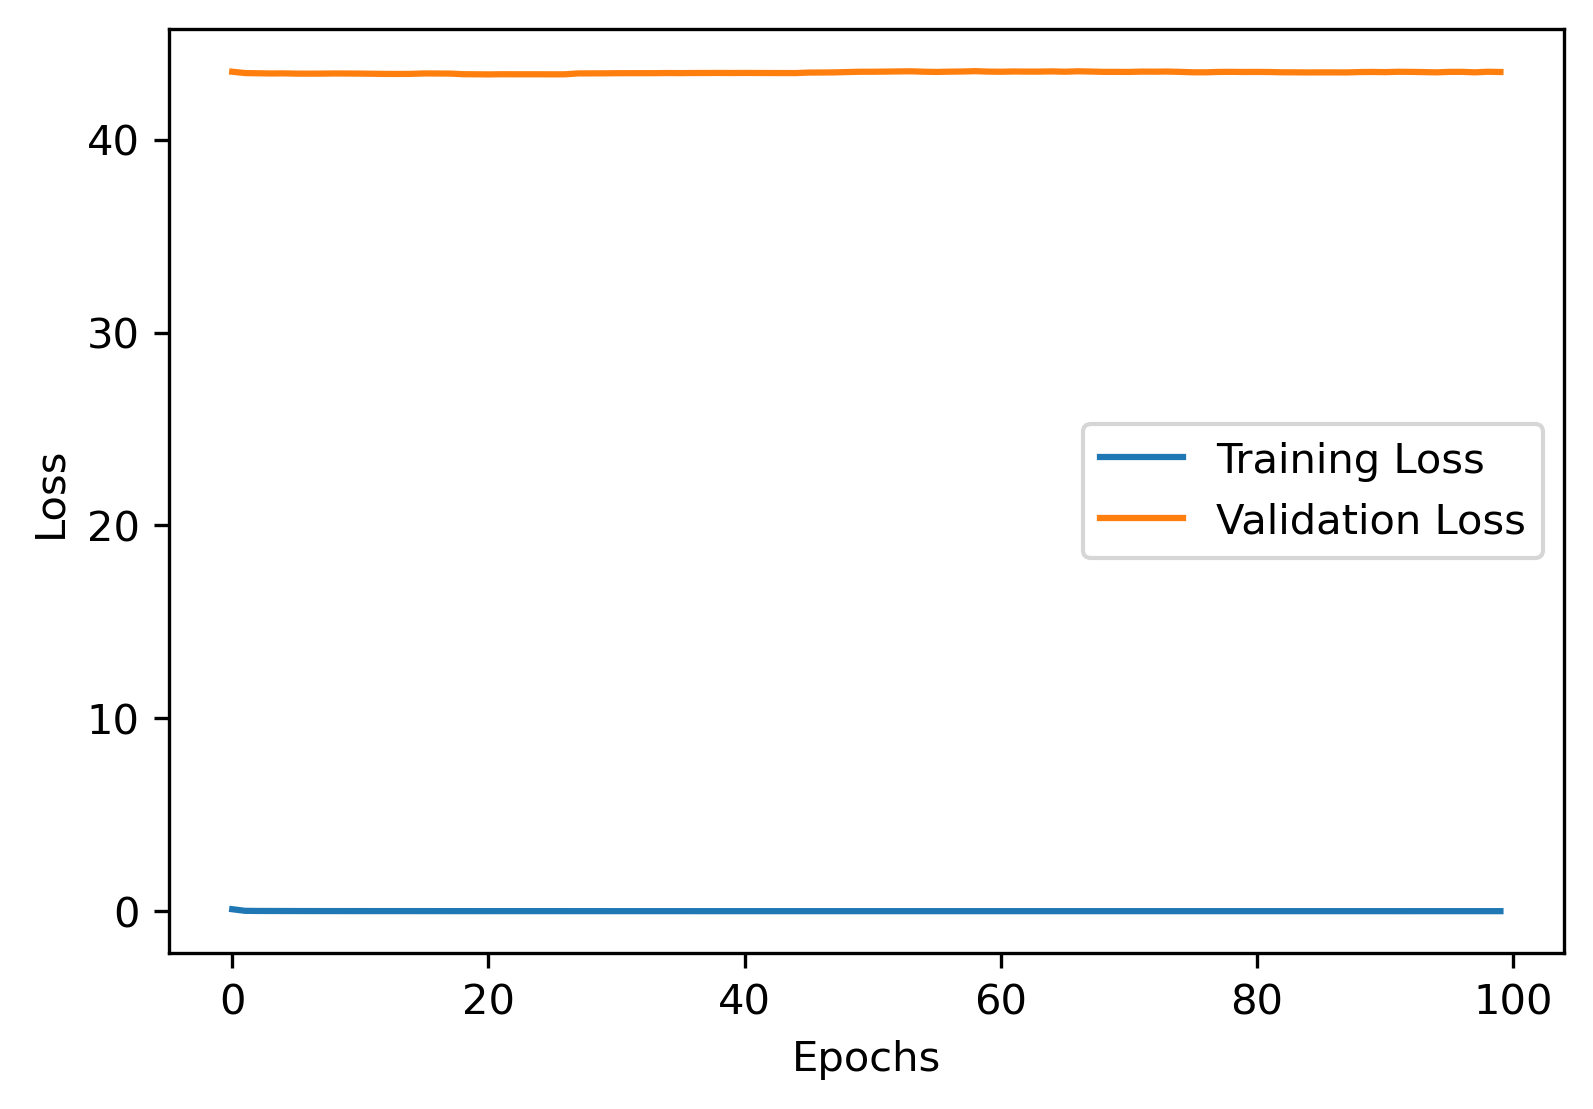

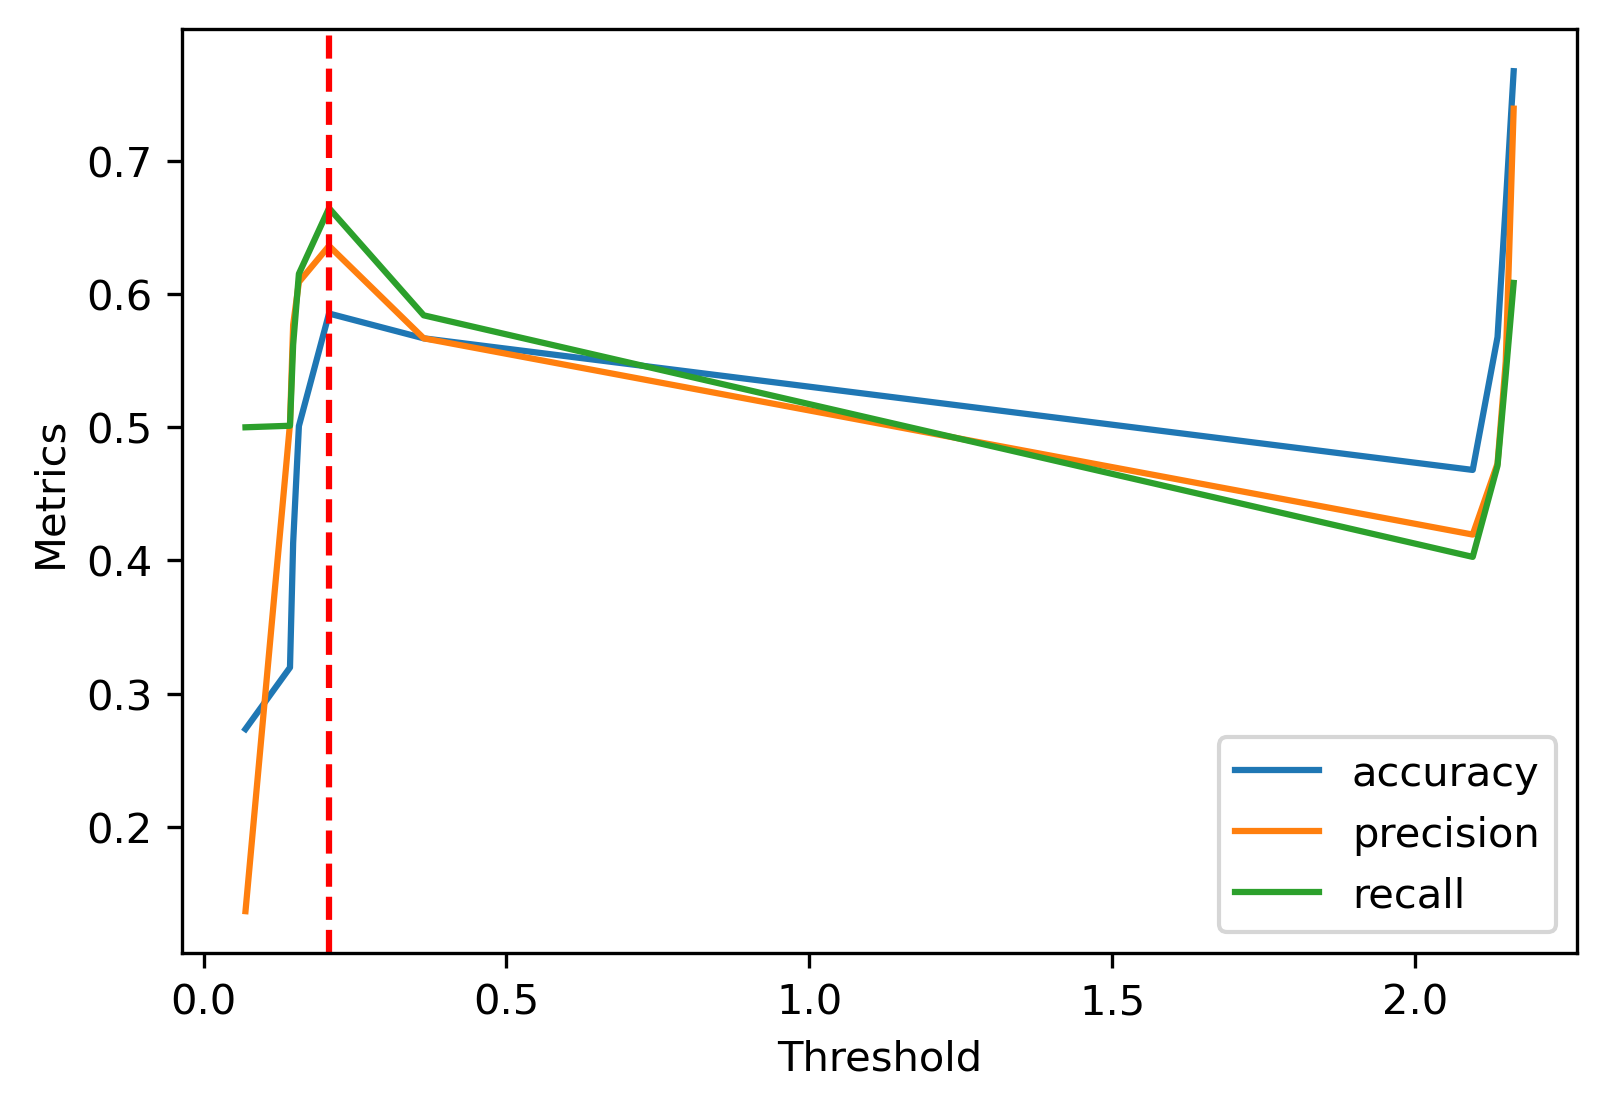

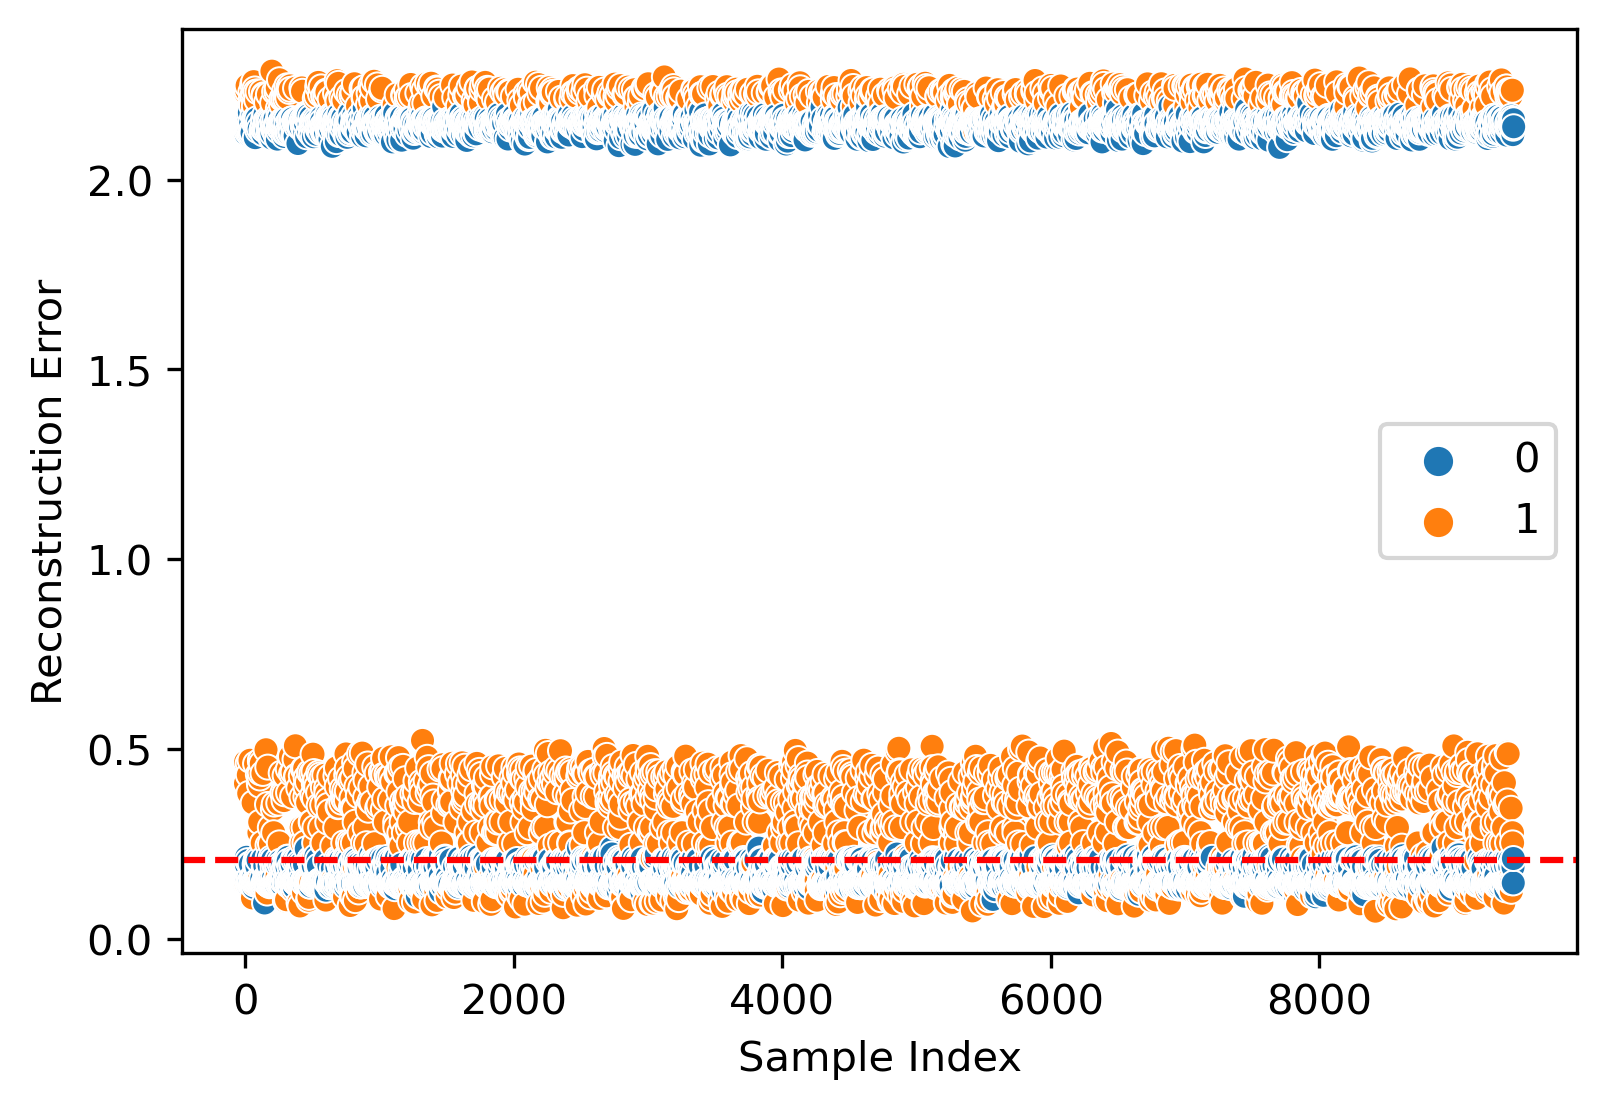

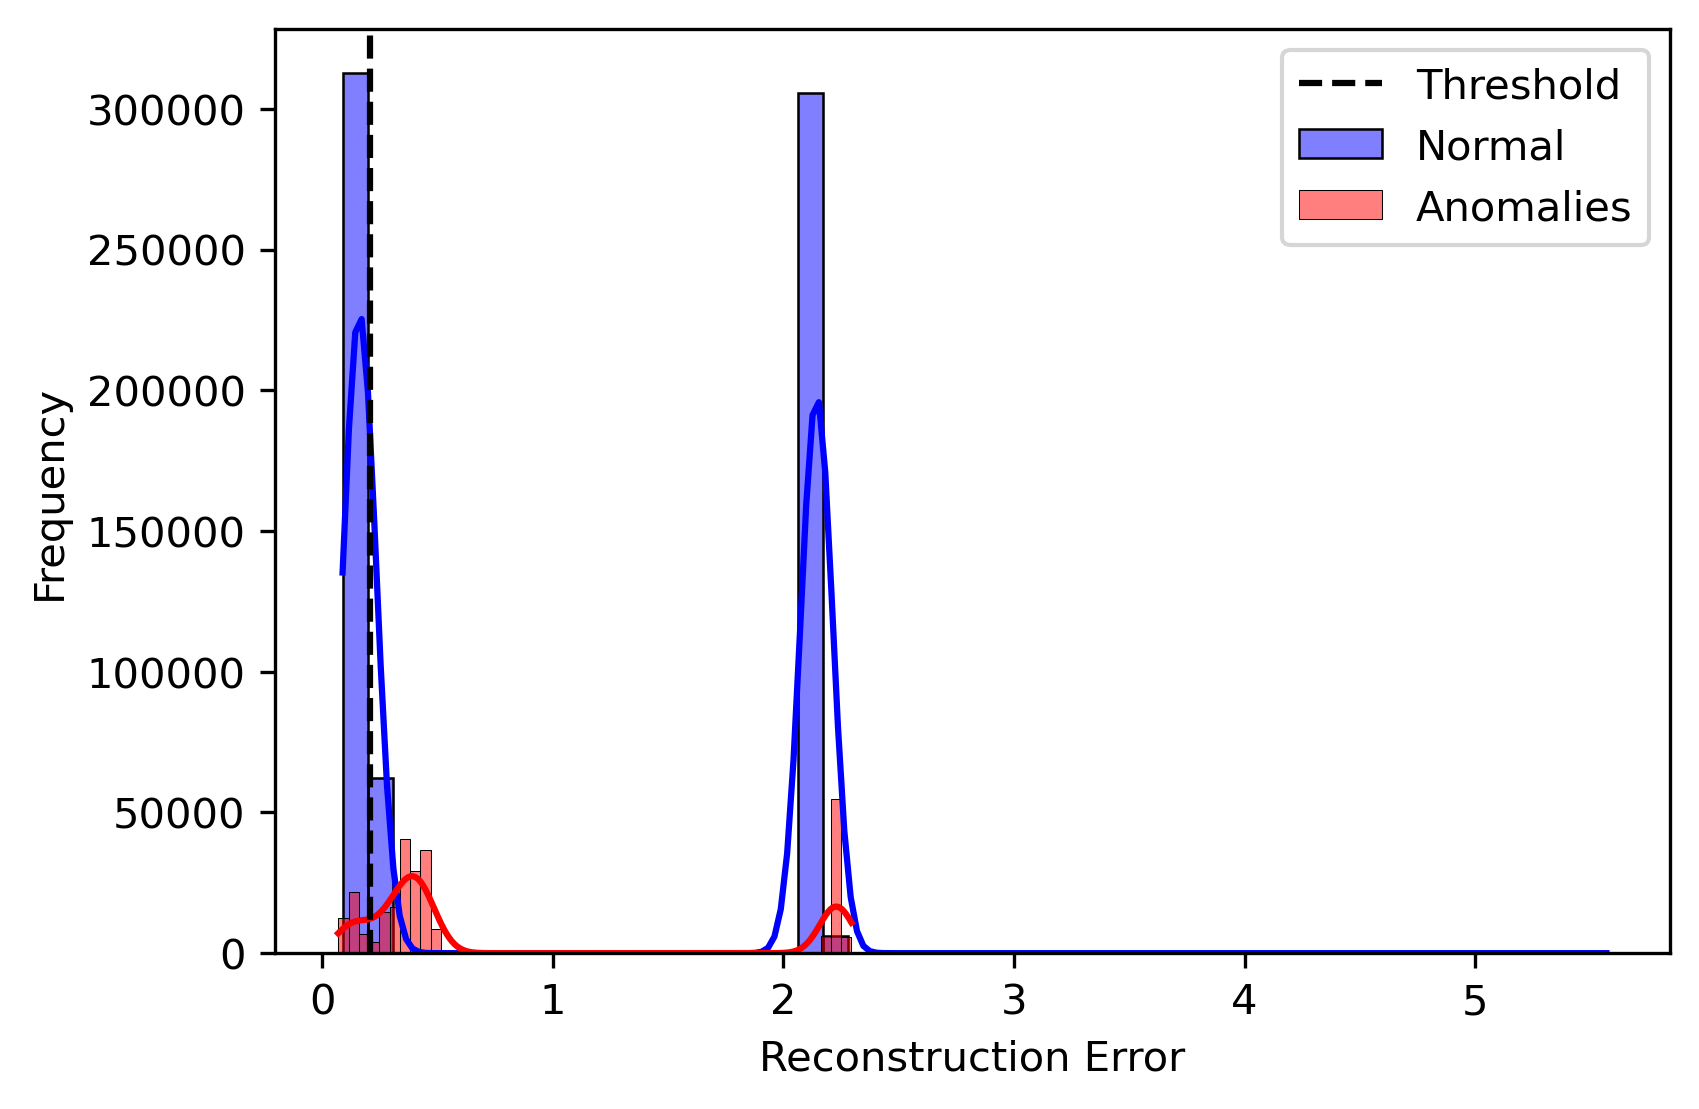

In [13]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('DNNTrad.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(6,4),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend()
plt.savefig('DNNTrad_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(6,4),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.savefig('DNNTrad_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(6,4),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('DNNTrad_Reconst.jpg')


# 2 DNN

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Define the Residual Autoencoder model
def build_residual_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers with residual connections
    encoded = Dense(encoding_dim, activation="relu")(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    skip_connection = Dense(encoding_dim // 2, activation="relu")(encoded)

    encoded = Dense(encoding_dim // 2, activation="relu")(skip_connection)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder layers with residual connections
    decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
    decoded = Add()([decoded, skip_connection])  # Adding skip connection here
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    
    return autoencoder

# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

Epoch 1/100
Epoch 1: CPU Usage: 8.80000% | Memory Usage: 15350.34766 MB
430/430 - 9s - 21ms/step - loss: 0.0058 - val_loss: 43.5046
Epoch 2/100
Epoch 2: CPU Usage: 13.00000% | Memory Usage: 15350.44531 MB
430/430 - 9s - 20ms/step - loss: 0.0058 - val_loss: 43.5074
Epoch 3/100
Epoch 3: CPU Usage: 14.90000% | Memory Usage: 15350.74609 MB
430/430 - 9s - 20ms/step - loss: 0.0058 - val_loss: 43.5026
Epoch 4/100
Epoch 4: CPU Usage: 4.40000% | Memory Usage: 15350.75000 MB
430/430 - 9s - 21ms/step - loss: 0.0058 - val_loss: 43.5118
Epoch 5/100
Epoch 5: CPU Usage: 9.00000% | Memory Usage: 15350.74219 MB
430/430 - 8s - 19ms/step - loss: 0.0058 - val_loss: 43.5088
Epoch 6/100
Epoch 6: CPU Usage: 13.80000% | Memory Usage: 15350.75000 MB
430/430 - 8s - 18ms/step - loss: 0.0058 - val_loss: 43.5074
Epoch 7/100
Epoch 7: CPU Usage: 19.70000% | Memory Usage: 15350.76172 MB
430/430 - 8s - 17ms/step - loss: 0.0058 - val_loss: 43.5152
Epoch 8/100
Epoch 8: CPU Usage: 9.70000% | Memory Usage: 15350.76172 MB


reconstruction_error tf.Tensor([0.29582729 0.12670131 0.09960288 ... 0.354042   0.13076768 0.34956376], shape=(945020,), dtype=float64)
      error  y_true
0  0.295827       1
1  0.126701       0
2  0.099603       1
3  0.364844       1
4  0.122833       0
Threshold: 0.0553	Accuracy: 0.273		Precision: 0.137	Recall Score: 0.500
Threshold: 0.1213	Accuracy: 0.328		Precision: 0.526	Recall Score: 0.512
Threshold: 0.1313	Accuracy: 0.411		Precision: 0.573	Recall Score: 0.559
Threshold: 0.1420	Accuracy: 0.500		Precision: 0.607	Recall Score: 0.614
Threshold: 0.1660	Accuracy: 0.589		Precision: 0.639	Recall Score: 0.669
Threshold: 0.2905	Accuracy: 0.567		Precision: 0.567	Recall Score: 0.584
Threshold: 2.0198	Accuracy: 0.468		Precision: 0.419	Recall Score: 0.403
Threshold: 2.0593	Accuracy: 0.568		Precision: 0.473	Recall Score: 0.471
Threshold: 2.0728	Accuracy: 0.668		Precision: 0.549	Recall Score: 0.540
Threshold: 2.0861	Accuracy: 0.767		Precision: 0.739	Recall Score: 0.608
Threshold with Maximum R

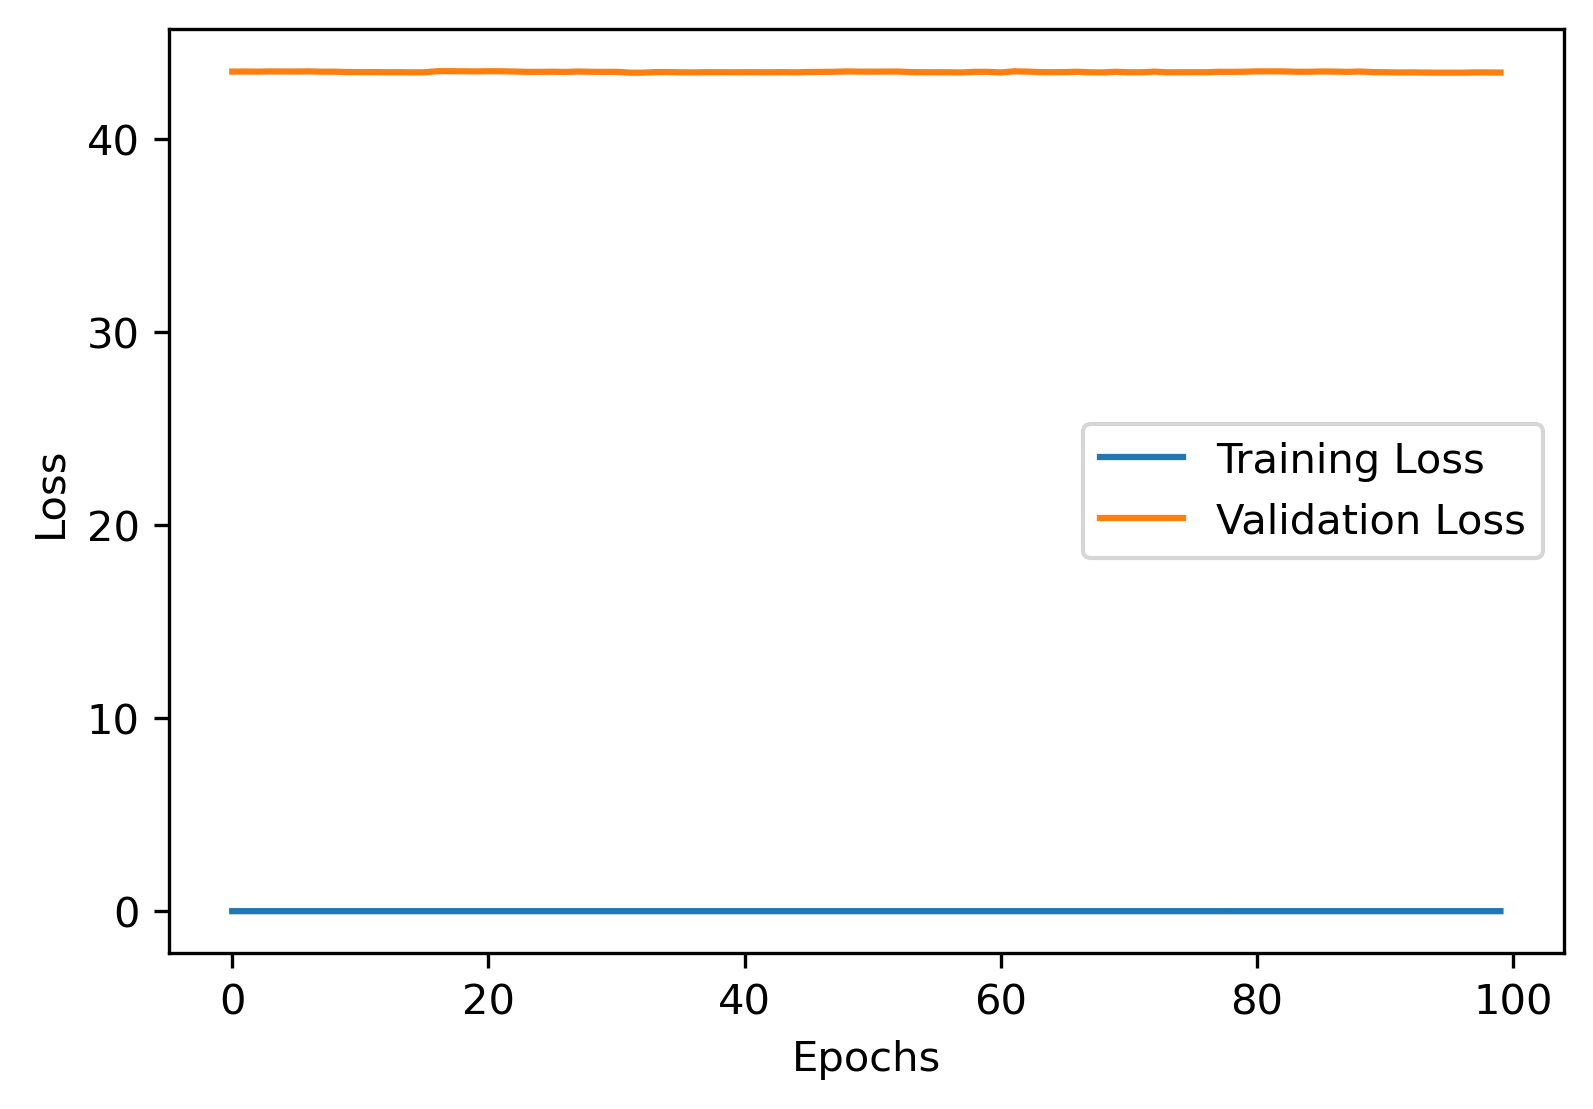

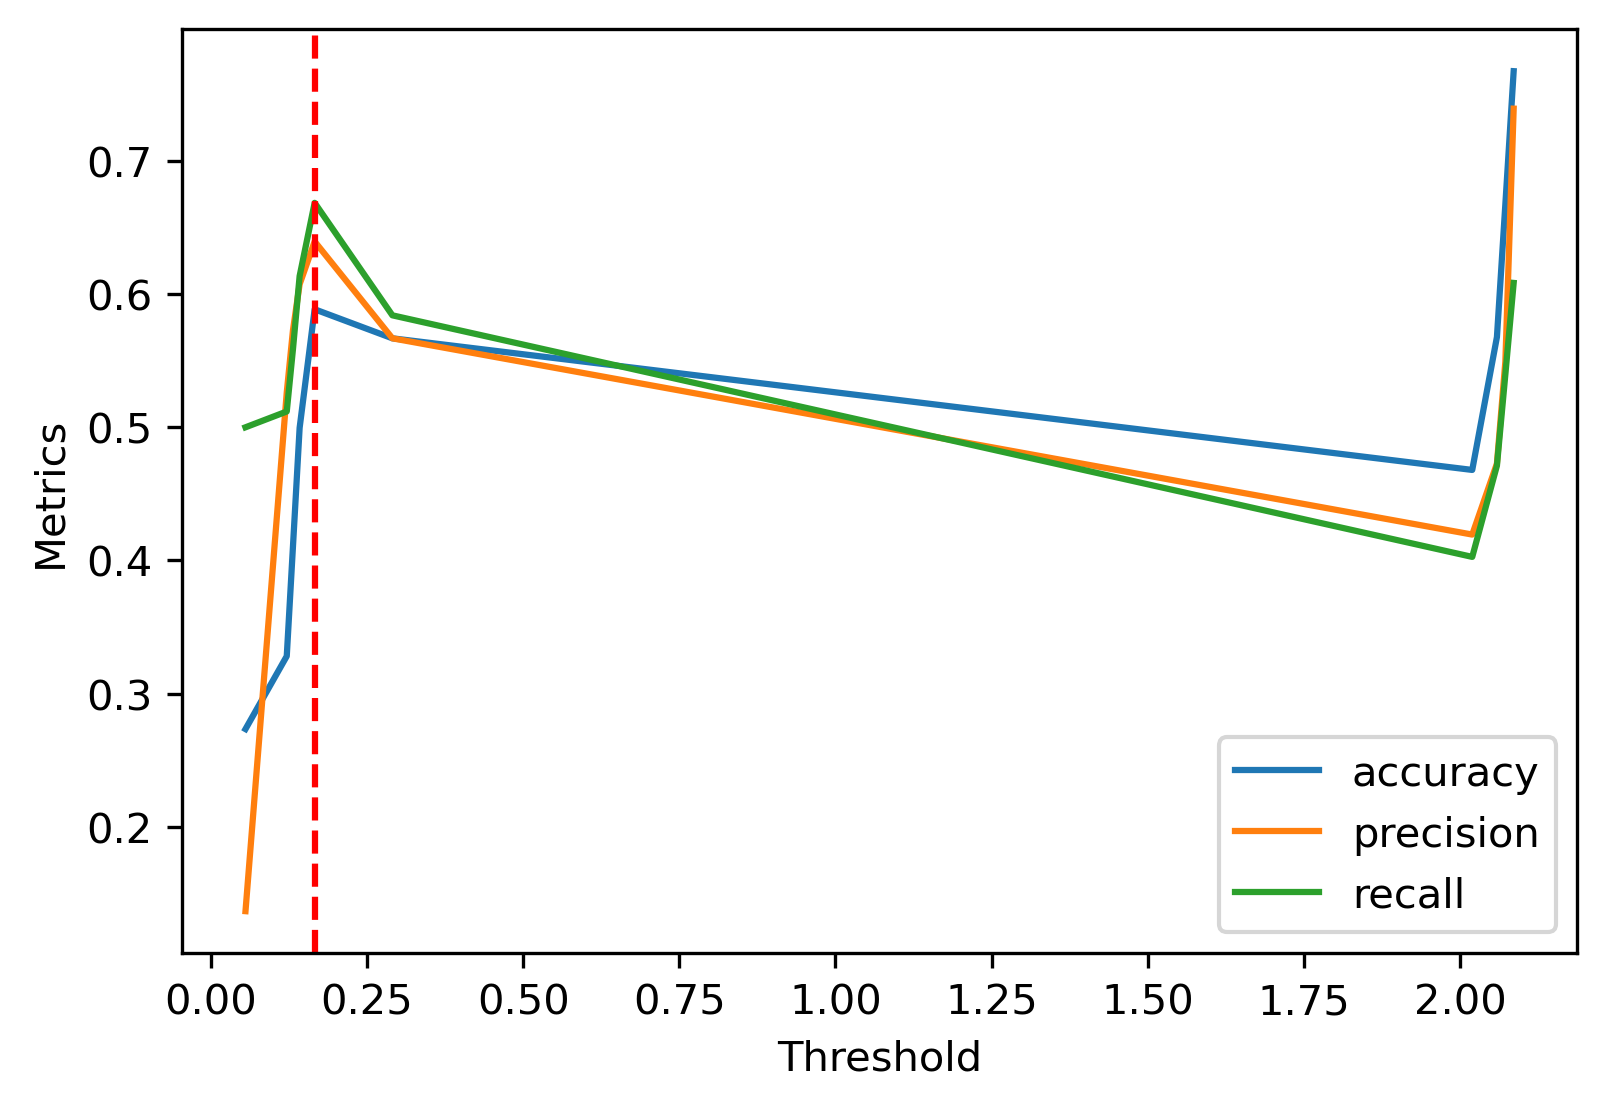

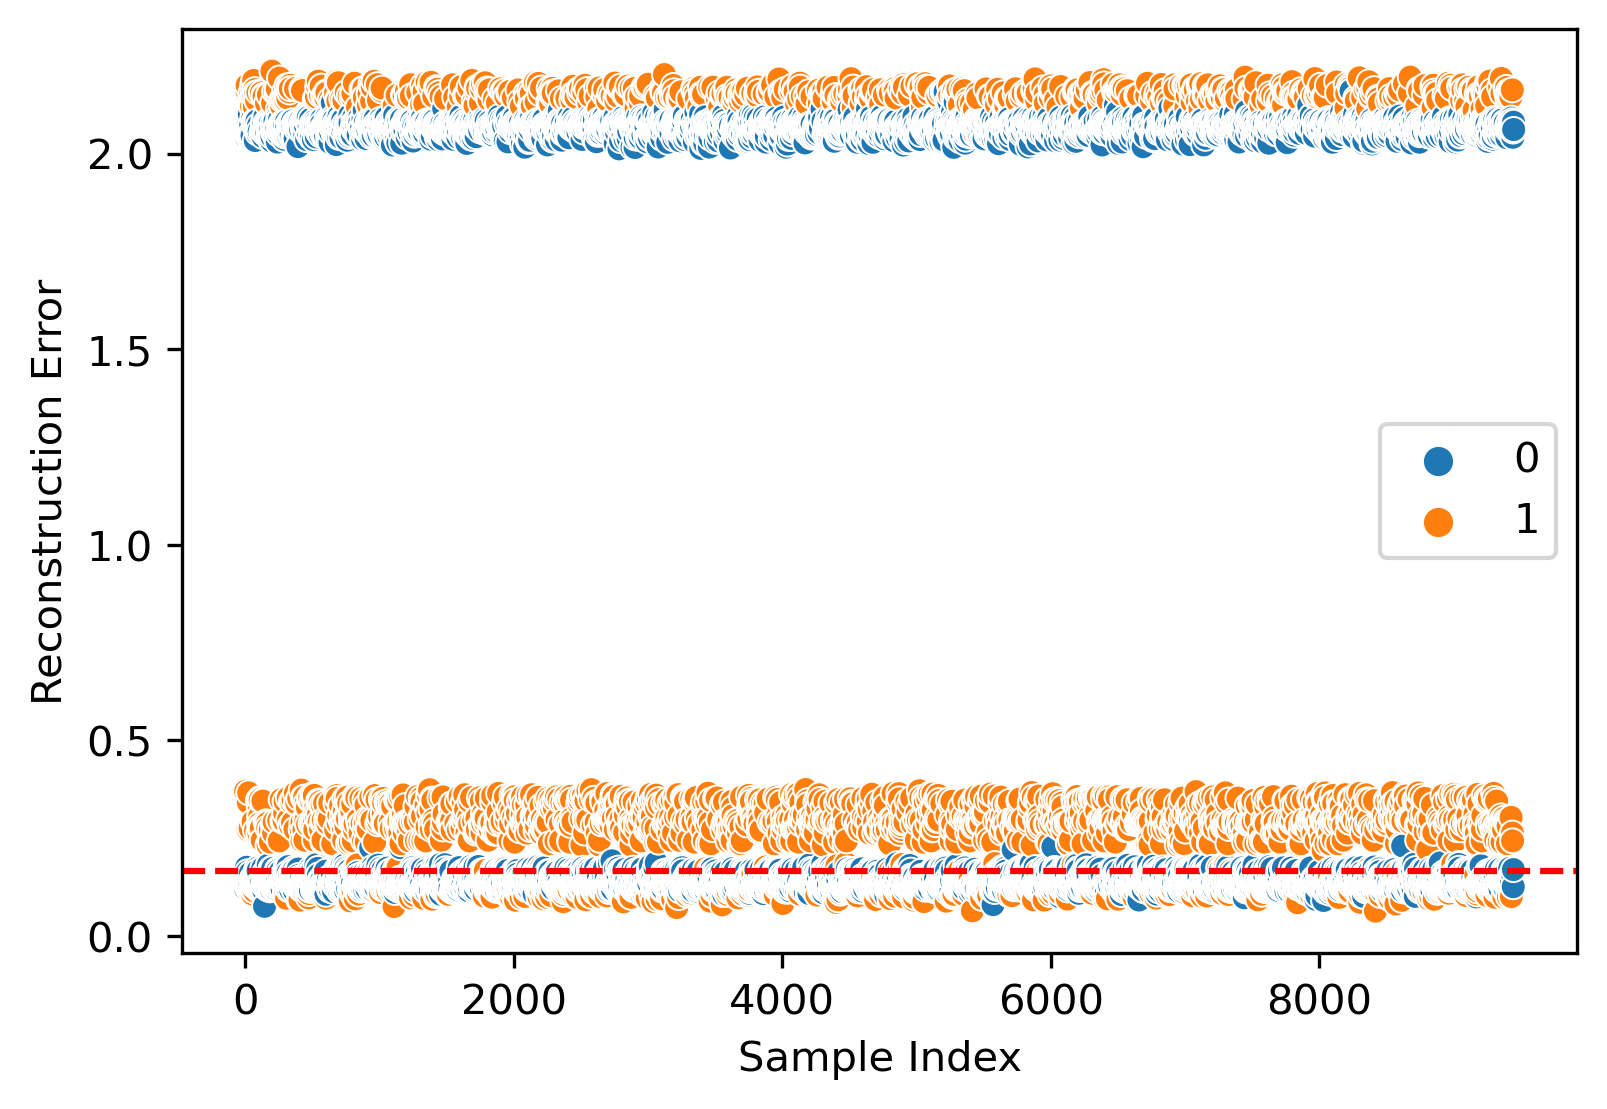

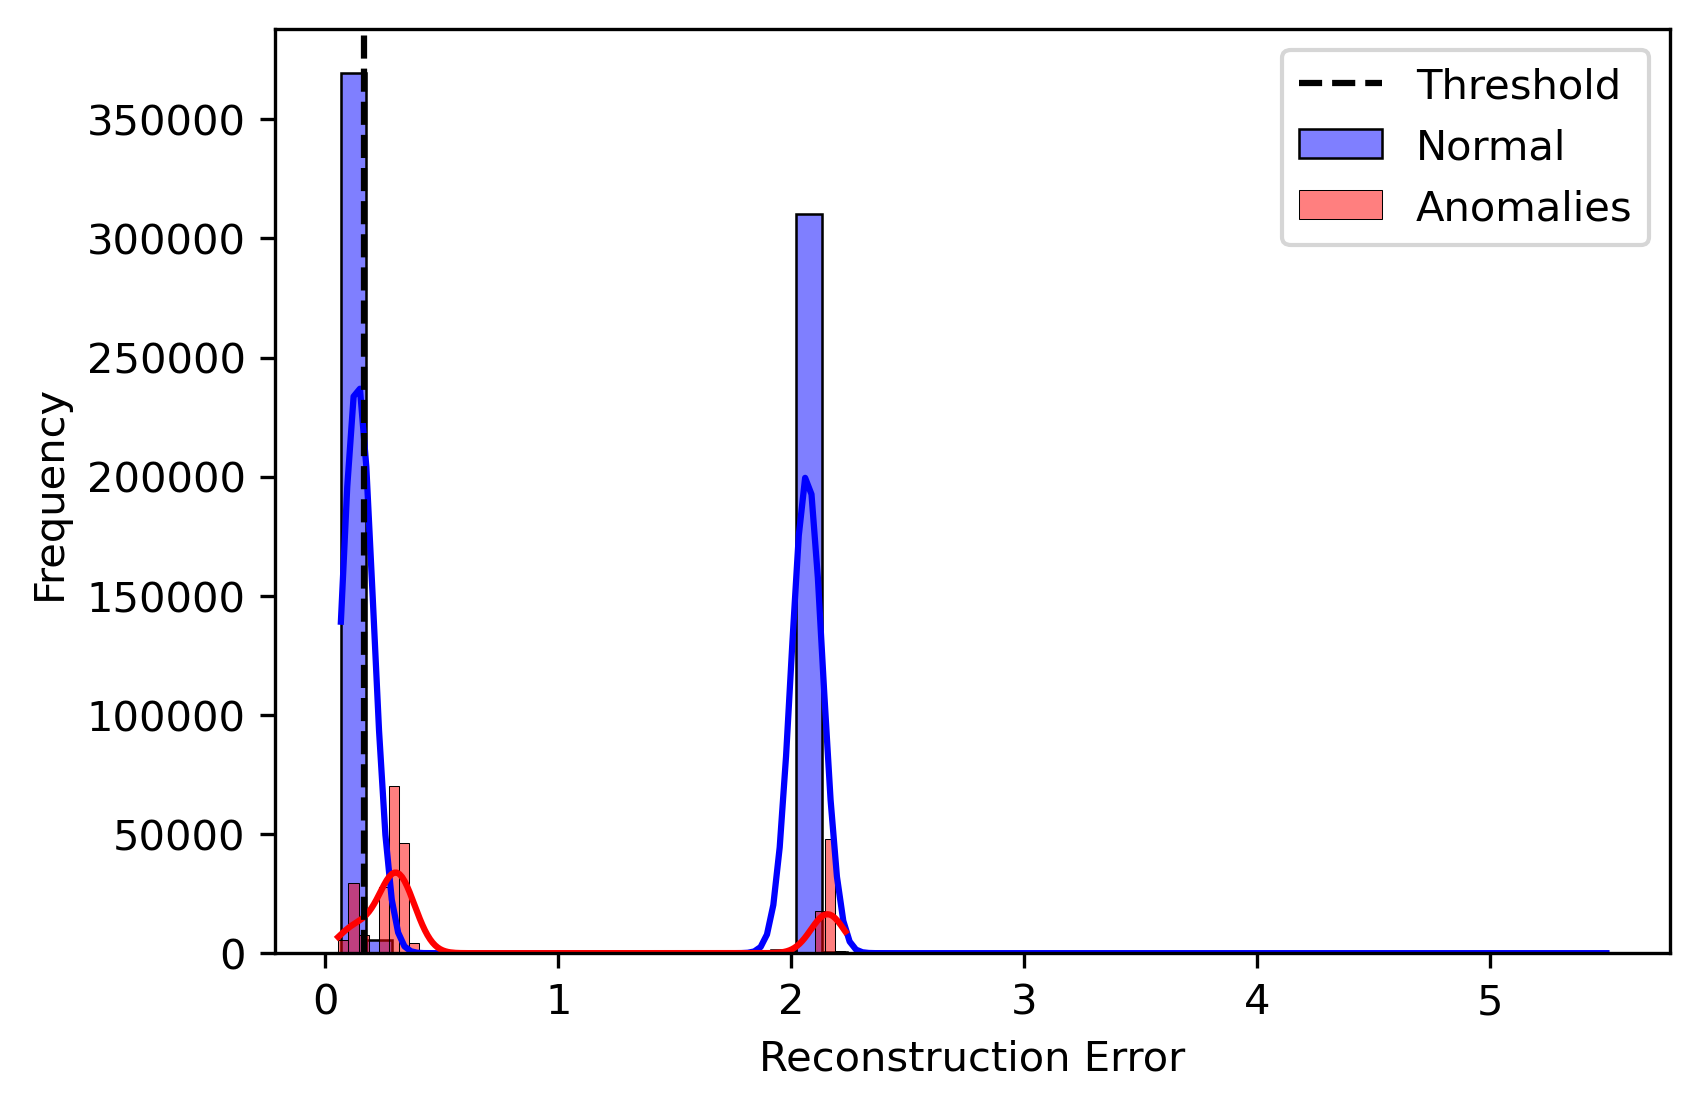

In [15]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('2DNNTrad.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(6,4),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend()
plt.savefig('2DNNTrad_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(6,4),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.savefig('2DNNTrad_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(6,4),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('2DNNTrad_Reconst.jpg')


# Conv1D

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam

# Define the CNN-based Autoencoder for 1D data
def create_cnn_autoencoder_1d(input_shape):
    # Encoder
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    
    # Latent space
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Crop the output to match the input shape
    x = Cropping1D(cropping=(1, 1))(x)  # Adjust cropping as needed
    output_layer = x
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Input data shape
input_shape = (38, 1)  # 38 features with 1 channel

# Create the model
autoencoder = create_cnn_autoencoder_1d(input_shape)

autoencoder.compile(optimizer="adam", loss="mse")


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

Epoch 1/100
Epoch 1: CPU Usage: 8.80000% | Memory Usage: 5541.27734 MB
430/430 - 53s - 123ms/step - loss: 0.0152 - val_loss: 43.3492
Epoch 2/100
Epoch 2: CPU Usage: 8.60000% | Memory Usage: 5542.67188 MB
430/430 - 49s - 113ms/step - loss: 7.9600e-04 - val_loss: 42.0350
Epoch 3/100
Epoch 3: CPU Usage: 12.30000% | Memory Usage: 5543.16406 MB
430/430 - 50s - 115ms/step - loss: 4.9365e-04 - val_loss: 42.0400
Epoch 4/100
Epoch 4: CPU Usage: 14.00000% | Memory Usage: 5544.14844 MB
430/430 - 48s - 112ms/step - loss: 3.1686e-04 - val_loss: 42.0416
Epoch 5/100
Epoch 5: CPU Usage: 10.50000% | Memory Usage: 5544.96094 MB
430/430 - 49s - 115ms/step - loss: 2.5020e-04 - val_loss: 42.0415
Epoch 6/100
Epoch 6: CPU Usage: 9.50000% | Memory Usage: 5545.32422 MB
430/430 - 49s - 113ms/step - loss: 2.1099e-04 - val_loss: 42.0402
Epoch 7/100
Epoch 7: CPU Usage: 12.10000% | Memory Usage: 5546.13281 MB
430/430 - 50s - 116ms/step - loss: 1.8499e-04 - val_loss: 42.0347
Epoch 8/100
Epoch 8: CPU Usage: 12.00000%

reconstruction_error tf.Tensor([0.11276839 0.09589501 0.11051772 ... 1.82950765 1.8394253  0.14818858], shape=(945009,), dtype=float64)
      error  y_true
0  0.112768       0
1  0.095895       0
2  0.110518       0
3  1.845453       0
4  1.785332       0
Threshold: 0.0141	Accuracy: 0.273		Precision: 0.137	Recall Score: 0.500
Threshold: 0.0983	Accuracy: 0.294		Precision: 0.432	Recall Score: 0.469
Threshold: 0.1042	Accuracy: 0.393		Precision: 0.545	Recall Score: 0.536
Threshold: 0.1101	Accuracy: 0.483		Precision: 0.588	Recall Score: 0.593
Threshold: 0.1352	Accuracy: 0.570		Precision: 0.620	Recall Score: 0.645
Threshold: 0.2902	Accuracy: 0.567		Precision: 0.567	Recall Score: 0.584
Threshold: 1.7554	Accuracy: 0.468		Precision: 0.420	Recall Score: 0.403
Threshold: 1.7954	Accuracy: 0.568		Precision: 0.473	Recall Score: 0.472
Threshold: 1.8241	Accuracy: 0.668		Precision: 0.550	Recall Score: 0.540
Threshold: 1.8582	Accuracy: 0.768		Precision: 0.740	Recall Score: 0.609
Threshold with Maximum R

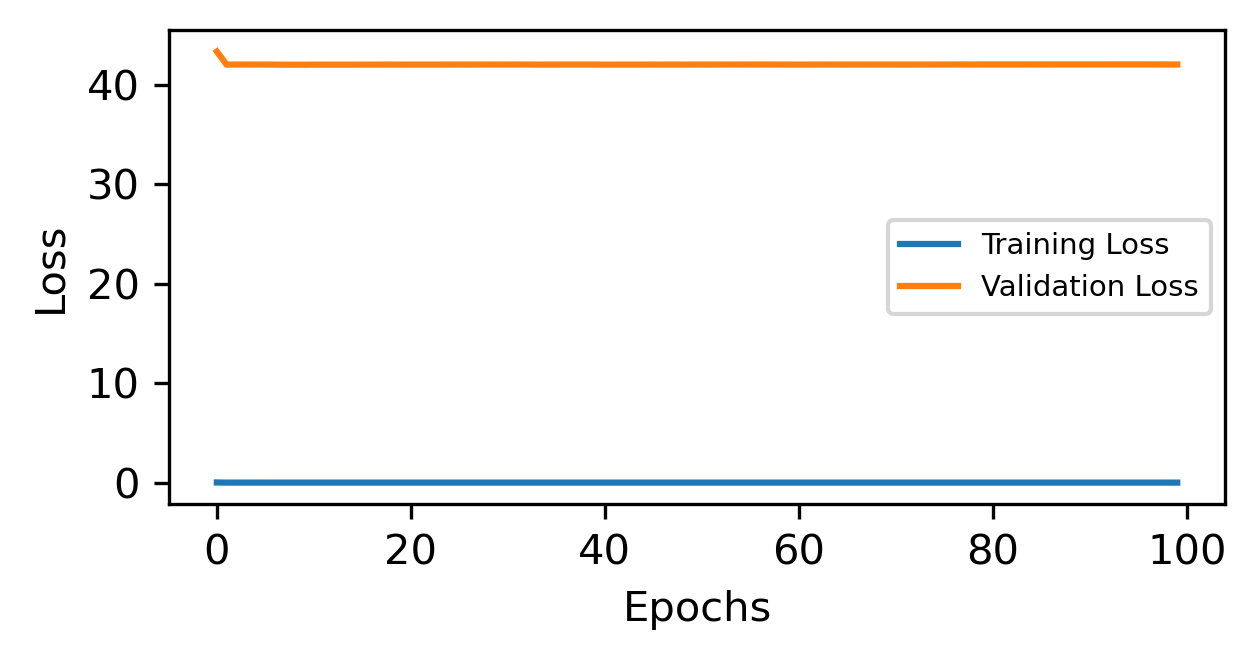

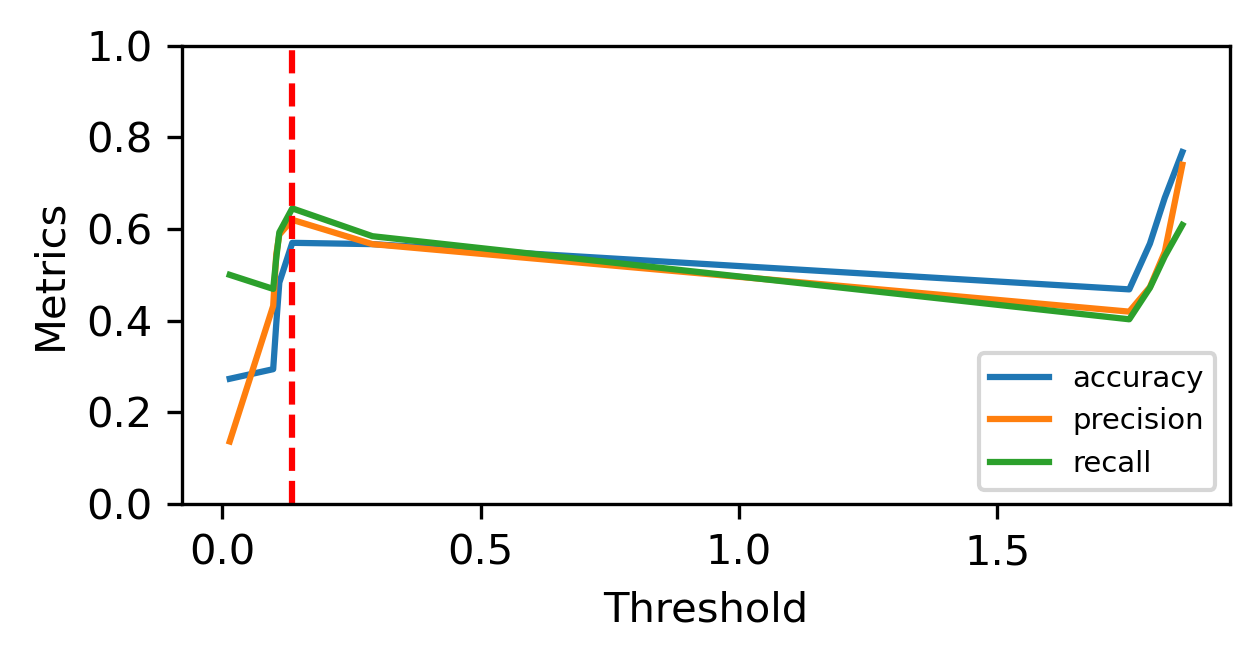

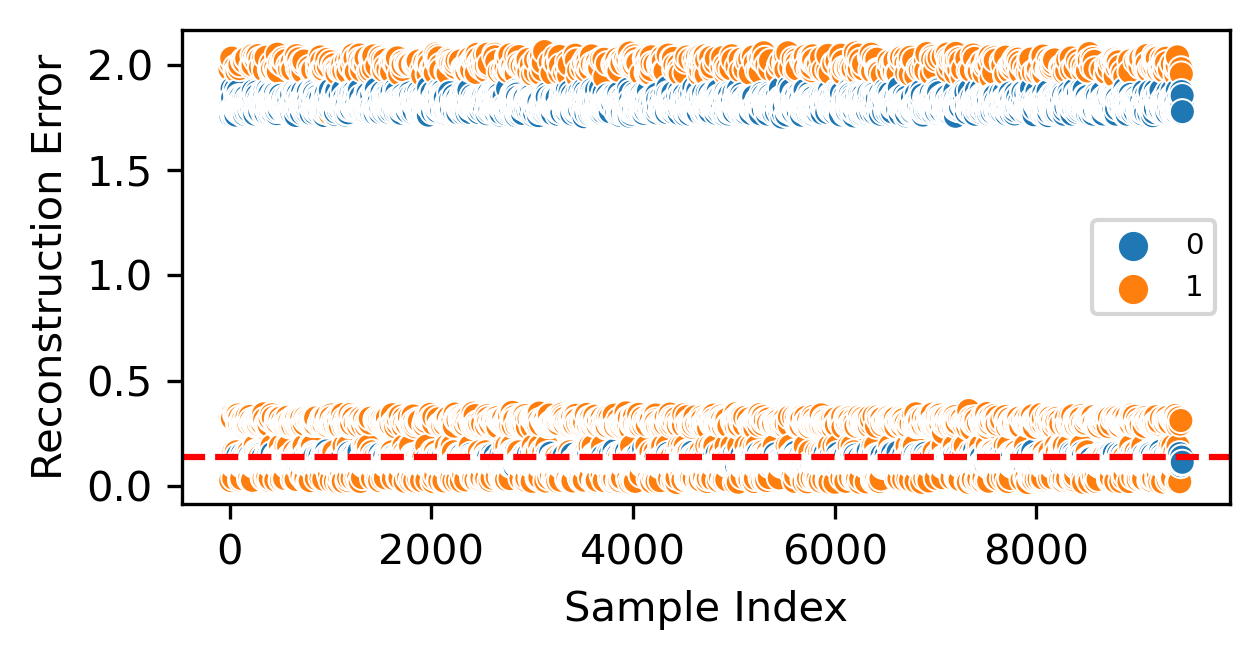

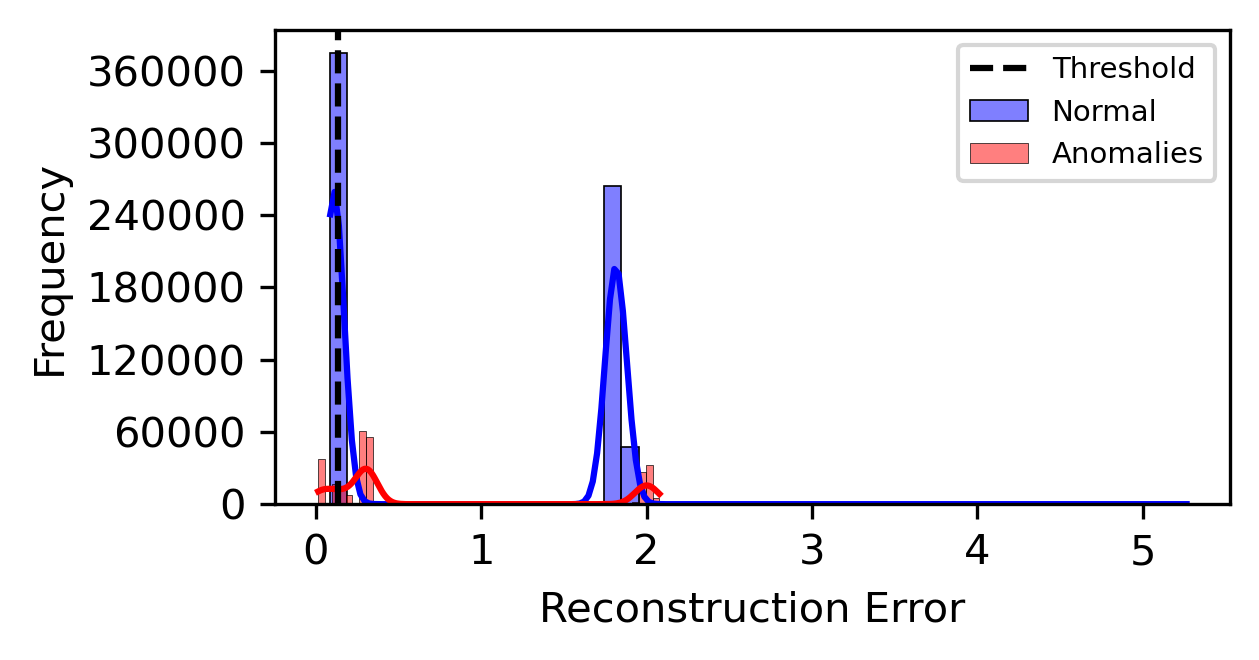

In [18]:
plt.figure(figsize=(4,2),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 7)
plt.tight_layout()
plt.tight_layout(pad=0)
plt.savefig('con1dTrad.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(4,2),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.yticks(np.arange(0, 1.2, 0.2))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dTrad_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(4,2),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.yticks(np.arange(0, 2.5, 0.5))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dTrad_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(4,2),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 6, 1))  # Corrected method
plt.yticks(range(0, 410000, 60000))  # Correct method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dTrad_Reconst.jpg')
